In [1]:
#Import packages
import urllib
import json
import re
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from bs4 import BeautifulSoup
from collections import defaultdict
%matplotlib inline

In [2]:
#Open schedule between start and end date (format YYYY-MM-DD)
def scheduleOpener(start, end):
    start = str(start)
    end = str(end)
    schedule = urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/schedule?startDate=%s&endDate=%s' % (start, end))
    scheduledata = json.loads(schedule.read().decode(schedule.info().get_param('charset') or 'utf-8'))
    return scheduledata

In [3]:
#Grab the game links from all the retrieved schedule data
def gameLinkRetrieval(scheduledata):
    assert type(scheduledata) == dict
    
    #Get games within the schedule
    daygames = [scheduledata['dates'][i]['games'] for i in range(len(scheduledata['dates']))]
    #Get all links to the games
    gamelinks = ['https://statsapi.web.nhl.com'+link['link'] for entry in daygames for link in entry]
    return gamelinks

In [4]:
#Load all the plays within the provided game link
def loadGamePlays(gamelink):
    #Open a game link
    game = urllib.request.urlopen(gamelink)
    gamedata = json.loads(game.read().decode(game.info().get_param('charset') or 'utf-8'))

    #Grab the data about every play that happened
    plays = gamedata['liveData']['plays']['allPlays']
    homeTeam = gamedata['gameData']['teams']['home']['name']
    return (plays, homeTeam)

In [5]:
#Get a list of all the plays which were either a shot or a goal
def shotsNGoals(plays):
    return [event for event in plays if event['result']['event'] in ['Shot', 'Goal']]

In [6]:
#Build up a dataframe from the list of shots and goals
def buildDf(shotsngoals, home):
    assert type(shotsngoals) == list
    
    #Get various information from each event in shotsngoals
    x = [event['coordinates']['x'] if (len(event['coordinates']) == 2) else np.nan for event in shotsngoals]
    y = [event['coordinates']['y'] if (len(event['coordinates']) == 2) else np.nan for event in shotsngoals]
    goals = [int(event['result']['event']=='Goal') for event in shotsngoals]
    shooterteam = [event['team']['name'] for event in shotsngoals]
    shooterhome = [1 if (st == home) else 0 for st in shooterteam]
    shooterid = [p['player']['id'] for event in shotsngoals for p in event['players'] if p['playerType'] in ['Shooter', 'Scorer']]
    period = [event['about']['period'] for event in shotsngoals]
    shottype = [event['result']['secondaryType'] if 'secondaryType' in list(event['result'].keys()) else 'NotRecorded' for event in shotsngoals]
    goalie = []
    goalieid = []
    for event in shotsngoals:
        ps = event['players']
        goaliefound = 0
        for entry in ps:
            if 'Goalie' in list(entry.values()):
                goalie.append(entry['player']['fullName'])
                goalieid.append(entry['player']['id'])
                goaliefound = 1
            else:
                continue
        if goaliefound == 0:
            goalie.append('None')
            goalieid.append('0')

    #Build up dataframe object for the game
    df = pd.DataFrame()
    df['ShooterTeam'] = shooterteam
    df['ShooterHome'] = shooterhome
    df['ShooterID'] = shooterid
    df['X'] = x
    df['Y'] = y
    df['Period'] = period
    df['ShotType'] = shottype
    df['Goalie'] = goalie
    df['GoalieID'] = goalieid
    df['Goal'] = goals
    
    return df

In [7]:
#Update the relevant goalie's stats
def updateGoalies(df):
    assert list(df.columns) == ['ShooterTeam','ShooterHome','ShooterID','X','Y','Period','ShotType','Goalie','GoalieID','Goal']
    
    #Goalies in game
    gig = list(df['GoalieID'].unique())
    
    #Store the key/value for goalie ID and goalie name, and append new stats
    for gid in gig:
        giddf = df[df['GoalieID']==gid].reset_index(drop=True)
        goalieIDs[gid] = giddf['Goalie'][0]
        
    for gid in gig:
        giddf = df[df['GoalieID']==gid]
        gStats = goalieStatsDict[gid]
        if len(gStats) == 0:
            goalieStatsDict[gid] = giddf
        else:
            goalieStatsDict[gid] = goalieStatsDict[gid].append(giddf)
            goalieStatsDict[gid] = goalieStatsDict[gid].reset_index(drop=True)

In [8]:
#Normalize the y-location so all shots can be displayed correctly on half the rink
def normalizeLoc(row):
    if (row['ShooterHome']==0 & row['Period']%2==1) or (row['ShooterHome']==1 & row['Period']%2==0):
        row['Y'] = row['Y']*(-1)
        return row
    else:
        return row

In [9]:
#Saving and loading functions
def saveDict(dictionary, filename):
    assert type(dictionary) == dict
    assert type(filename) == str
    
    np.save(filename, dictionary)
    
def loadDict(filename):
    assert type(filename) == str
    
    return np.load(filename).item()

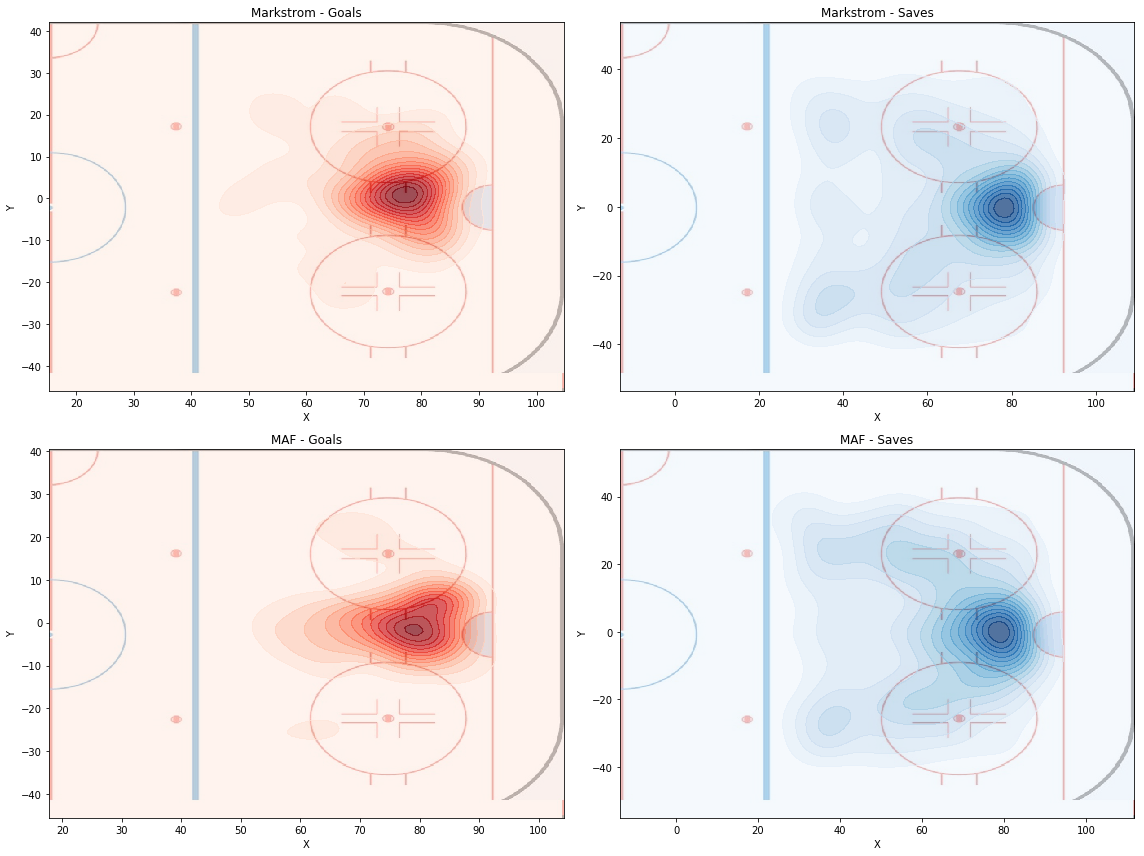

In [15]:
#Load file for 2018/2019 season (previously collected) and visualize Markstrom vs Fleury
gDict = loadDict('goalieStats2018.npy')
gIDs = loadDict('goalieIDs2018.npy')

#Pick stats, remove nulls, normalize locations
mkstats = gDict[8474593]
markstromstats = mkstats[mkstats['Y'].isnull()==False]
mfstats = gDict[8470594]
mafstats = mfstats[mfstats['Y'].isnull()==False]
mkstats = mkstats.apply(normalizeLoc, axis=1)
mafstats = mafstats.apply(normalizeLoc, axis=1)

#Split on goal/no-goal
goals = markstromstats[markstromstats['Goal']==1]
saves = markstromstats[markstromstats['Goal']==0]
mafgoals = mafstats[mafstats['Goal']==1]
mafsaves = mafstats[mafstats['Goal']==0]

#Load the image overlay
map_img = mpimg.imread('halfrink.jpg')

#Plot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16,12))
mg = sns.kdeplot(abs(goals['X']), goals['Y'], shade=True, n_levels=15, cmap='Reds', ax=axs[0,0], alpha=0.7, zorder=2)
mg.imshow(map_img, aspect=mg.get_aspect(), extent=mg.get_xlim()+mg.get_ylim(),
         zorder=1)

ms = sns.kdeplot(abs(saves['X']), saves['Y'], shade=True, n_levels=15, cmap='Blues', ax=axs[0,1], alpha=0.7, zorder=2)
ms.imshow(map_img, aspect=ms.get_aspect(), extent=ms.get_xlim()+ms.get_ylim(),
         zorder=1)

mafg = sns.kdeplot(abs(mafgoals['X']), mafgoals['Y'], shade=True, n_levels=15, cmap='Reds', ax=axs[1,0], alpha=0.7, zorder=2)
mafg.imshow(map_img, aspect=mafg.get_aspect(), extent=mafg.get_xlim()+mafg.get_ylim(),
         zorder=1)

mafs = sns.kdeplot(abs(mafsaves['X']), mafsaves['Y'], shade=True, n_levels=15, cmap='Blues', ax=axs[1,1], alpha=0.7, zorder=2)
mafs.imshow(map_img, aspect=mafs.get_aspect(), extent=mafs.get_xlim()+mafs.get_ylim(),
         zorder=1)

#Plot options
axs[0,0].set_title('Markstrom - Goals')
axs[0,1].set_title('Markstrom - Saves')
axs[1,0].set_title('MAF - Goals')
axs[1,1].set_title('MAF - Saves')
plt.tight_layout()